## Imports

In [87]:
import glob
import html
import re
import string
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

from datetime import datetime

## Functions

In [2]:
def parse_HTML(text):
    clean = re.compile('<.*?>')
    return html.unescape(" ".join(re.sub(clean, '', text).split())) \
        .replace("“", '"').replace("”", '"').replace("‘", "'").replace("’", "'")


# Returns terms retrieved from text 't'
def all_terms(t):
    # Stop-words removal
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(t)
    filtered_text = [w for w in word_tokens if w not in stop_words]

    # Case folding
    lowerCaseList = list(map(str.lower, filtered_text))

    # Stemming
    global ps
    stemmed = [ps.stem(w) for w in lowerCaseList]

    # Removing punctuation and contractions
    noPunctuation = [''.join(c for c in s if c not in string.punctuation + "‘" + "’" + "“" + "”") for s in stemmed]
    noPunctuation = [s for s in noPunctuation if s]
    return [i for i in noPunctuation if i not in ('ve', 're', 't', 'nt', 'd', 'll')]

## Initializing variables

In [50]:
files = glob.glob("English/*.txt")
pList, allSentences, allDocuments, dCounter, angerWords = {}, {}, {}, 0, {}
trustTerms = ["loyalty", "reliance", "fraud", "forgery", "trust", "confidence", "covenant", "pledge",
              "promise", "warn", "alert", "flatter", "compliment", "periphrasis", "lie"]
# Getting the anger words from the wne file
with open('anger.wne') as f:
    ps = PorterStemmer()
    angerWords = set(word_tokenize(f.read()))
    trustTerms_stemmed = [ps.stem(word) for word in trustTerms]
    reversed_stemming_trust = dict(zip(trustTerms_stemmed, trustTerms))
angerWords = np.unique([ps.stem(w) for w in angerWords])

## Main logic

In [51]:
startTime = datetime.now()
# for file in [files[0], files[1], files[2], files[3], files[4]]:
for file in files:
    dCounter += 1
    f = open(file)
    allDocuments["D{}".format(dCounter)] = f.name
    text = f.read()
    f.close()
    text = parse_HTML(text)
    sentences = sent_tokenize(text)

    sCounter = 0
    for sentence in sentences:  # Storing sentences in relation to documents
        sCounter += 1
        allSentences["D{}S{}".format(dCounter, sCounter)] = sentence
        for term in all_terms(sentence):  # Creating postings list
            if term not in pList:
                pList[term] = ["D{}S{}".format(dCounter, sCounter)]
            else:
                pList.get(term).append("D{}S{}".format(dCounter, sCounter))


document_count = dict((i, 0) for i in allDocuments)
trust_terms_intersection = list(pList.keys() & trustTerms_stemmed)
trust_terms_locations = [pList.get(word) for word in trust_terms_intersection]
trust_terms = dict(zip(trust_terms_intersection, trust_terms_locations))
anger_word_intersection = pList.keys() & angerWords
anger_word_locations = [pList.get(word) for word in anger_word_intersection]
anger_words = dict(zip(anger_word_intersection, anger_word_locations))

cooccurrence_result = dict((i, 0) for i in trust_terms)
for trust_term in trust_terms:
    t_counter = 0
    for t_loc in trust_terms[trust_term]:
        for anger_word in anger_words:
            for a_loc in anger_words[anger_word]:
                if t_loc == a_loc:
                    t_counter += 1
                    document_count[a_loc.partition("S")[0]] += 1
    cooccurrence_result[trust_term] = t_counter

print("Total runtime:\t\t\t\t"+str(datetime.now() - startTime))

Total runtime:				0:00:34.854855


## Displaying results

In [52]:
df = pd.DataFrame(document_count.items(), columns=["Document", "Trust-Anger co-occurrence count"])
for _, doc in df.iterrows():
    df = df.replace(doc["Document"], allDocuments[doc["Document"]].replace('English\\ ', ''))
df = df.sort_values(by=['Trust-Anger co-occurrence count'], ascending=False)
df_view = df.style.set_properties(**{'text-align': 'left'})
pd.set_option('display.max_colwidth', None)
display("Documents sorted by the amount of trust words appearing the the same sentence as anger words:")
df_view

'Documents sorted by the amount of trust words appearing the the same sentence as anger words:'

,Document,Trust-Anger co-occurrence count
52,Biden calls for healing in appeal to Trump voters Live news.txt,6
415,Iran vows ‘crushing’ response after NYT says Trump mulled attack.txt,5
689,UN experts call Morsi’s death in Egypt ‘arbitrary killing’.txt,5
607,Sinai Peninsula Sisi’s offensive continues despite promises.txt,5
735,Whitewashing George HW Bush’s legacy.txt,4
125,Did Donald Trump ignore dire coronavirus warnings.txt,4
631,The lost promise of Barack Obama.txt,4
464,Michelle Obama brands Donald Trump ‘racist’ in scalding video.txt,4
396,Human rights From Obama to Trump.txt,4
85,Can Hillary Clinton beat Donald Trump.txt,3


In [75]:
display('"Angriest" document:')
df.loc[df['Trust-Anger co-occurrence count'].idxmax()]

'"Angriest" document:'

Document                           Biden calls for healing in appeal to Trump voters Live news.txt
Trust-Anger co-occurrence count                                                                  6
Name: 52, dtype: object

In [86]:
print("Average co-occurrence count of the trust words with the 'anger' words, which contain at least 1 match:\t{}".format(np.mean(df[df["Trust-Anger co-occurrence count"] > 0]["Trust-Anger co-occurrence count"])))
print("Average co-occurrence count of the trust words with the 'anger' words:\t{}".format(np.mean(df["Trust-Anger co-occurrence count"])))

Average co-occurrence count of the trust words with the 'anger' words, which contain at least 1 match:	1.58
Average co-occurrence count of the trust words with the 'anger' words:	0.30659767141009053


#### With the given documents, there's about a 30% chance for a document to contain at least one sentence with a trust word AND an anger word.

In [60]:
df2 = pd.DataFrame(cooccurrence_result.items(), columns=["Trust word", "Trust-Anger co-occurrence count"])
for _, word in df2.iterrows():
    df2 = df2.replace(word["Trust word"], reversed_stemming_trust[word["Trust word"]])
df2 = df2.sort_values(by=['Trust-Anger co-occurrence count'], ascending=False)
df2_view = df2.style.set_properties(**{'text-align': 'left'})
display("Trust words with their co-occurence with 'angry' words:")
df2_view

"Trust words with their co-occurence with 'angry' words:"

,Trust word,Trust-Anger co-occurrence count
12,promise,76
6,warn,63
8,pledge,23
9,lie,22
3,fraud,18
10,trust,16
5,confidence,12
0,forgery,4
4,loyalty,2
2,reliance,1


### We can see that the trust word "promise" has 76 co-occurrences with an 'anger' word in the same sentence. We speculate that this implies that many of the "promises" mentioned were probably broken in some way, and the author of these documents was angry about it.

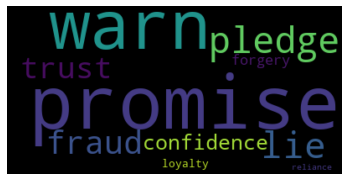

In [92]:
# Create and generate a word cloud image:
tuples = [tuple(x) for x in df2.values]
wordcloud = WordCloud().generate_from_frequencies(dict(tuples))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

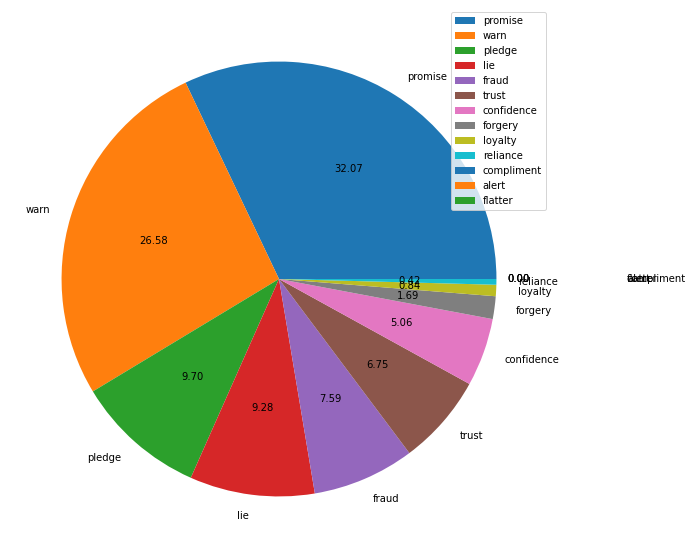

In [119]:
plt.rcParams["figure.figsize"] = (20,10)
plt.pie(df2["Trust-Anger co-occurrence count"], labels = df2["Trust word"], autopct='%.2f', explode=[0.5 if i>9 else 0 for i in np.arange(len(df2))])
plt.legend()
plt.show() 